In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve)

# TensorFlow imports
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, callbacks
    TF_AVAILABLE = True
    print(f"TensorFlow {tf.__version__} available")
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow not available")
    raise ImportError("Install TensorFlow: pip install tensorflow")

import warnings
warnings.filterwarnings('ignore')

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

print("Libraries imported successfully")
print("=" * 60)

TensorFlow 2.20.0 available
Libraries imported successfully


#  1: Load Preprocessed Data

In [7]:
print("Loading preprocessed data...")

with open('../models/preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
feature_names = data['feature_names']

print("Data loaded successfully:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Number of features: {len(feature_names)}")


Loading preprocessed data...
Data loaded successfully:
  X_train shape: (5634, 30)
  X_test shape: (1409, 30)
  y_train shape: (5634,)
  y_test shape: (1409,)
  Number of features: 30


#   2: Baseline Neural Network


In [8]:
print("\nTraining Baseline Neural Network...")

# Function to create a simple neural network
def create_simple_nn(input_dim):
    """Create a simple neural network model."""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train baseline model
baseline_nn = create_simple_nn(X_train.shape[1])
baseline_nn.summary()

# Train the model
print("Training baseline model...")
baseline_history = baseline_nn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)

print("Baseline model trained!")

# Make predictions
y_train_pred_proba = baseline_nn.predict(X_train, verbose=0)
y_test_pred_proba = baseline_nn.predict(X_test, verbose=0)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Calculate metrics
print("\nBaseline Model Performance:")
print("=" * 40)
print("Training Set:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_train_pred):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_pred_proba):.4f}")


Training Baseline Neural Network...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

Training baseline model...
Baseline model trained!

Baseline Model Performance:
Training Set:
  Accuracy:  0.8443
  Precision: 0.7659
  Recall:    0.5953
  F1-Score:  0.6699

Test Set:
  Accuracy:  0.7807
  Precision: 0.6102
  Recall:    0.4813
  F1-Score:  0.5381
  ROC-AUC:   0.8172


#  3: Hyperparameter Tuning

In [9]:
print("\n Starting Hyperparameter Tuning...")

# Function to create model for tuning
def create_tunable_nn(hidden_units=64, dropout_rate=0.3, learning_rate=0.001):
    """Create neural network with tunable parameters."""
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_units // 2, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    return model

# Manual hyperparameter tuning (simple approach)
print(" Testing different hyperparameters...")

# Test different configurations
configs = [
    {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01},
    {'hidden_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'hidden_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
]

best_score = 0
best_config = None
best_model = None

for i, config in enumerate(configs):
    print(f"\nTesting config {i+1}: {config}")

    model = create_tunable_nn(**config)

    # Train with early stopping
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate
    y_pred_proba = model.predict(X_test, verbose=0)
    score = roc_auc_score(y_test, y_pred_proba)
    print(f"  ROC-AUC: {score:.4f}")

    if score > best_score:
        best_score = score
        best_config = config
        best_model = model

print(f"\nBest configuration: {best_config}")
print(f"Best ROC-AUC: {best_score:.4f}")


 Starting Hyperparameter Tuning...
 Testing different hyperparameters...

Testing config 1: {'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01}
  ROC-AUC: 0.8402

Testing config 2: {'hidden_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
  ROC-AUC: 0.8424

Testing config 3: {'hidden_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
  ROC-AUC: 0.8426

Best configuration: {'hidden_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
Best ROC-AUC: 0.8426


#  4: Train Model


In [10]:
print("\nTraining Best Neural Network...")

# Train final model with best config
final_nn = create_tunable_nn(**best_config)

# Setup callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model
print("Training final model...")
final_history = final_nn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

print("Final model trained!")

# Make predictions with best model
y_train_pred_proba_best = final_nn.predict(X_train, verbose=0)
y_test_pred_proba_best = final_nn.predict(X_test, verbose=0)
y_train_pred_best = (y_train_pred_proba_best > 0.5).astype(int)
y_test_pred_best = (y_test_pred_proba_best > 0.5).astype(int)

print("\nBest Model Performance:")
print("=" * 40)
print("Training Set:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_best):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_best):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_best):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_train_pred_best):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred_best):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_best):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_best):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred_best):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_pred_proba_best):.4f}")



Training Best Neural Network...
Training final model...
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7404 - auc: 0.7424 - loss: 0.5102 - val_accuracy: 0.7933 - val_auc: 0.8141 - val_loss: 0.4472 - learning_rate: 5.0000e-04
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7928 - auc: 0.8187 - loss: 0.4465 - val_accuracy: 0.7986 - val_auc: 0.8209 - val_loss: 0.4412 - learning_rate: 5.0000e-04
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7952 - auc: 0.8279 - loss: 0.4370 - val_accuracy: 0.7933 - val_auc: 0.8235 - val_loss: 0.4387 - learning_rate: 5.0000e-04
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - auc: 0.8350 - loss: 0.4306 - val_accuracy: 0.7968 - val_auc: 0.8246 - val_loss: 0.4401 - learning_rate: 5.0000e-04
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - auc: 0.8378 - loss: 0.4274 - val_accuracy: 0.7986 - val_auc: 0.8261 - val_loss: 0.4360 - learning_rate: 5.0000e-0

## 5: Model Evaluation



 Model Evaluation Visualizations...


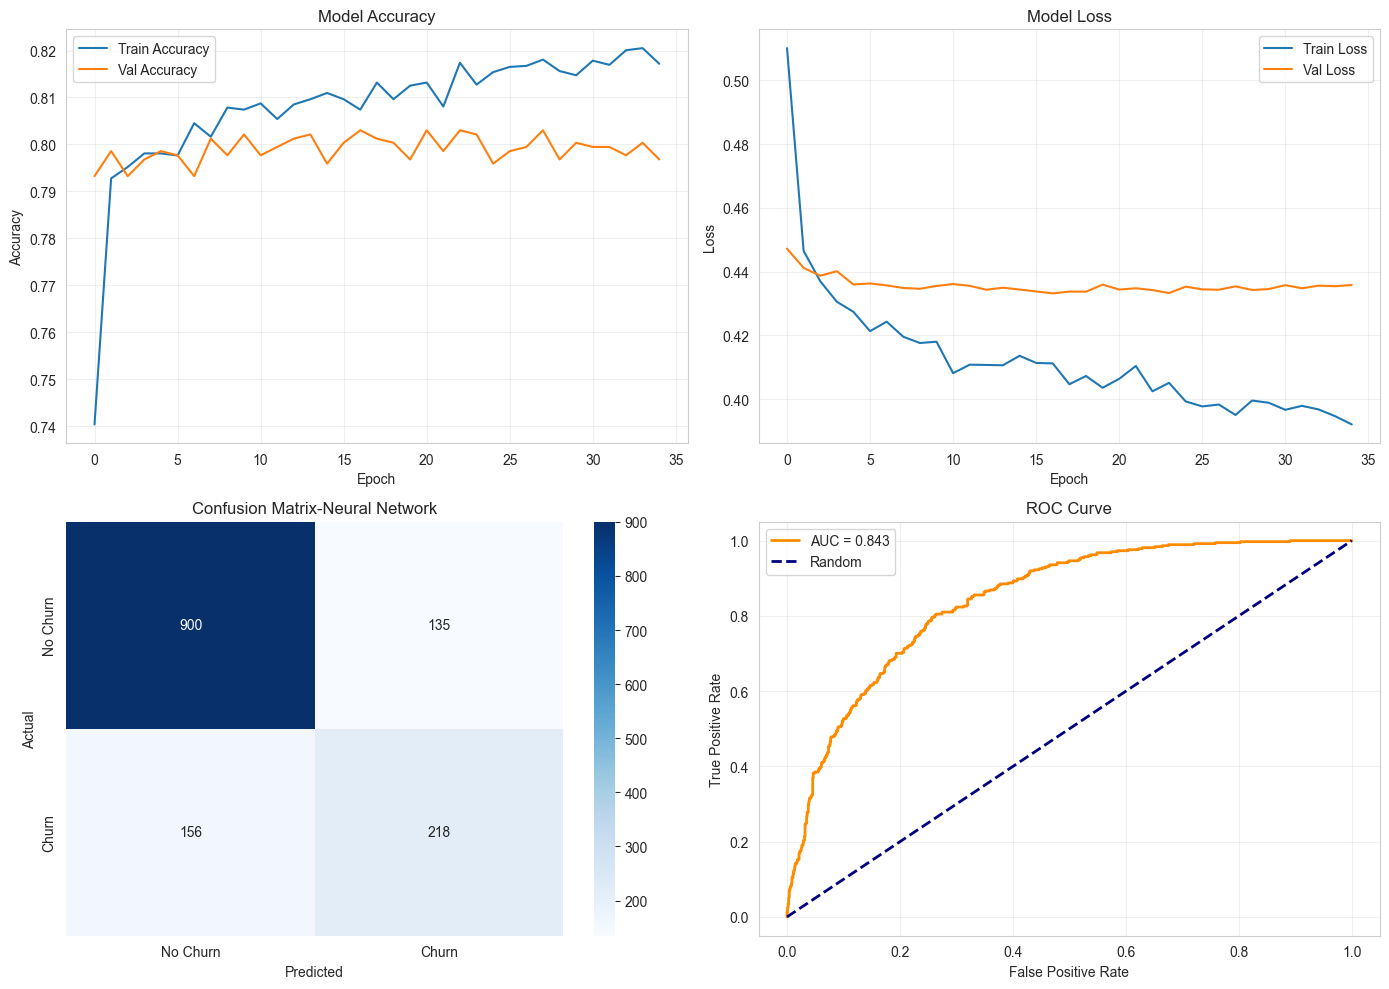


 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.87      0.86      1035
       Churn       0.62      0.58      0.60       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



In [16]:
print("\n Model Evaluation Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Training History
axes[0, 0].plot(final_history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(final_history.history['val_accuracy'], label='Val Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(final_history.history['loss'], label='Train Loss')
axes[0, 1].plot(final_history.history['val_loss'], label='Val Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1, 0].set_title('Confusion Matrix-Neural Network')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xlabel('Predicted')

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_best)
axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1, 1].set_title('ROC Curve')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_test_pred_best,
                           target_names=['No Churn', 'Churn']))

## 6: Model Comparison (Baseline and Tuned)


 Model Comparison: Baseline and Tuned

 Performance Comparison:
   Metric  Baseline    Tuned
 Accuracy  0.780696 0.793471
Precision  0.610169 0.617564
   Recall  0.481283 0.582888
 F1-Score  0.538117 0.599725
  ROC-AUC  0.817213 0.842863


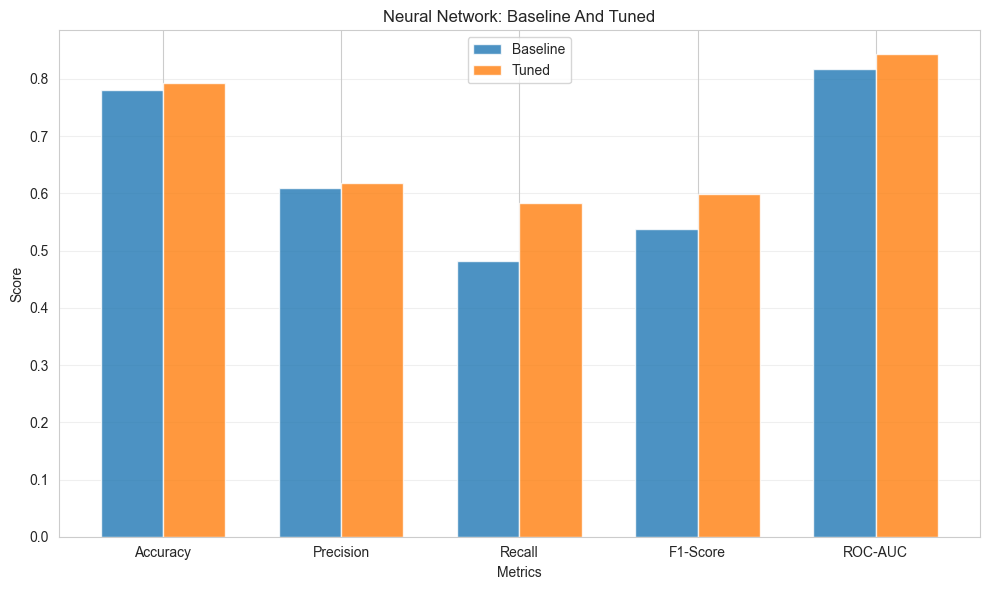

In [15]:
print("\n Model Comparison: Baseline and Tuned")

#  baseline metrics
baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1': f1_score(y_test, y_test_pred),
    'roc_auc': roc_auc_score(y_test, y_test_pred_proba)
}

#  tuned metrics
tuned_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred_best),
    'precision': precision_score(y_test, y_test_pred_best),
    'recall': recall_score(y_test, y_test_pred_best),
    'f1': f1_score(y_test, y_test_pred_best),
    'roc_auc': roc_auc_score(y_test, y_test_pred_proba_best)
}

# comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [baseline_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']],
    'Tuned': [tuned_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
})

print("\n Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visual comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', alpha=0.8)
plt.bar(x + width/2, comparison_df['Tuned'], width, label='Tuned', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Neural Network: Baseline And Tuned')
plt.xticks(x, comparison_df['Metric'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


##  7: Save Model and Results

In [110]:
print("\n Saving model and results...")

# Create results dictionary
results = {
    'model': final_nn,
    'best_config': best_config,
    'baseline_metrics': baseline_metrics,
    'tuned_metrics': tuned_metrics,
    'test_predictions': y_test_pred_best,
    'test_probabilities': y_test_pred_proba_best,
    'history': final_history.history,
    'confusion_matrix': cm,
    'feature_names': feature_names
}

# Save to file using pickle
save_path = '../models/neural_network_model.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

final_nn.save('../models/neural_network_model.keras')

print(f" Neural Network model saved to: {save_path}")
print(f"  Keras model saved to: ../models/neural_network_model.keras")

print("\n Final Metrics Summary:")
for metric, value in tuned_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")


 Saving model and results...
 Neural Network model saved to: ../models/neural_network_model.pkl
  Keras model saved to: ../models/neural_network_model.keras

 Final Metrics Summary:
  Accuracy: 0.7949
  Precision: 0.6139
  Recall: 0.6123
  F1: 0.6131
  Roc_auc: 0.8418
